In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from tqdm import tqdm
import seaborn as sns

In [ ]:
class KineticMonteCarlo:
    def __init__(self, lattice_size, e_ads, e_int_abs, time_array, time_factor, seed=None, T = 300):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.e_ads = e_ads
        self.e_int_abs = e_int_abs
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)  

    def pick_random_site(self):
        i, j = self.rng.integers(0, self.lattice_size, size=2)        
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def activation_energies(self, site):
        n_ij = self.count_occupied_neighbors(site)
        ads = self.e_int_abs * n_ij + self.e_ads
        return ads

    def calculate_transition_rates(self, site):
        E_ads= self.activation_energies(site)
        k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
        return k_ads

    def run_simulation(self):

        end_time = self.time_array[-1]

        while self.time < end_time:

            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    per_adsorption = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100
                    self.occupancy[t] = per_adsorption


            site = self.pick_random_site()
            k_ads = self.calculate_transition_rates(site)

            if k_ads == 0:
                break  # No more events possible
            
            delta_t = (-np.log(self.rng.random()) / k_ads)/self.factor
            self.time += delta_t

            self.lattice[site] = 1
                


        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                per_adsorption = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100
                self.occupancy[t] = per_adsorption
                
        

In [3]:
class BayesianOptimization:
    def __init__(self, model_class, exp_data, time_array, space, n_calls, random_state=42):
        self.model_class = model_class
        self.exp_data = exp_data
        self.time_array = time_array
        self.space = space
        self.n_calls = n_calls
        self.random_state = random_state
        self.best_params = None
        self.best_error = float("inf")
        self.progress_bar = tqdm(total=n_calls, desc="Optimización Bayesiana en Progreso", position=0)
        self.start_time = None

    def loss_function(self, params):
        e_ads, e_int_abs, lattice_size = params  

        kmc_model = self.model_class(
            lattice_size=lattice_size, e_ads=e_ads, e_int_abs=e_int_abs, time_factor=1e-7,
            time_array=self.time_array
        )
        kmc_model.run_simulation()

        simulated_data = np.array(list(kmc_model.occupancy.values()))
        error = np.mean((simulated_data - self.exp_data) ** 2)

        if error < self.best_error:
            self.best_error = error
            self.best_params = params
            print(f"🟢 Nuevo mejor error: {self.best_error:.6f} con parámetros {self.best_params}")

        elapsed_time = time.time() - self.start_time
        avg_time_per_iter = elapsed_time / (self.progress_bar.n + 1)
        estimated_time_left = avg_time_per_iter * (self.n_calls - self.progress_bar.n - 1)

        self.progress_bar.set_postfix({
            "Tiempo transcurrido": f"{elapsed_time:.2f} s",
            "Tiempo restante": f"{estimated_time_left:.2f} s",
            "Mejor error": f"{self.best_error:.6f}"
        })
        
        self.progress_bar.update(1)

        return error

    def optimize(self):
        self.start_time = time.time()
        result = gp_minimize(self.loss_function, self.space, n_calls=self.n_calls, random_state=self.random_state)
        self.progress_bar.close()

        end_time = time.time()
        print("\n✅ Optimización completada")
        print("🔹 Parámetros óptimos encontrados:", self.best_params)
        print("🔹 Error mínimo encontrado:", self.best_error)
        print(f"⏳ Tiempo total de ejecución: {end_time - self.start_time:.2f} segundos")

In [4]:
data = pd.read_csv('Datos recogidos.csv')
t = np.array([1,3,6,9,12,20,40,60])

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.iloc[3] = data.iloc[3] * 10
data.reset_index(drop=True, inplace=True)
data.insert(0, 'T0', 0)

data

,T0,T1,T2,T3,T4,T5,T6,T7,T8
0,0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587
1,0,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691
2,0,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964
3,0,11.453131,16.961002,22.642191,31.064719,36.995999,40.164993,40.562844,41.061651
4,0,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360
5,0,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871
6,0,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965
7,0,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876
8,0,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996
9,0,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952


In [6]:
# Definir los parámetros necesarios
model_class = KineticMonteCarlo
exp_data = data.iloc[8]
time_array = np.array([0,1,3,6,9,12,20,40,60])
space = [
    Real(0, 0.4, name="e_ads"),
    Real(0, 0.4, name="e_int_abs"),
    Integer(60, 100, name="lattice_size")
]
n_calls = 200
random_state = 42

# Crear una instancia de la clase BayesianOptimization
bayes_opt = BayesianOptimization(model_class=model_class, exp_data=exp_data, time_array=time_array, space=space, n_calls=n_calls, random_state=random_state)

# Ejecutar la optimización
bayes_opt.optimize()

Optimización Bayesiana en Progreso:   4%|▍         | 9/200 [00:00<00:01, 103.25it/s, Tiempo transcurrido=0.09 s, Tiempo restante=1.66 s, Mejor error=555.575354]

🟢 Nuevo mejor error: 1310.793087 con parámetros [0.3186171947440932, 0.07337391594646553, np.int64(91)]
🟢 Nuevo mejor error: 1106.711440 con parámetros [0.18369955678634692, 0.13348344445560875, np.int64(66)]
🟢 Nuevo mejor error: 555.575354 con parámetros [0.2603553891795412, 0.02256463161084011, np.int64(89)]


Optimización Bayesiana en Progreso:   6%|▌         | 11/200 [00:00<00:06, 28.79it/s, Tiempo transcurrido=0.38 s, Tiempo restante=6.55 s, Mejor error=152.942778]

🟢 Nuevo mejor error: 152.942778 con parámetros [0.23626065356038342, 0.011273901599606291, np.int64(91)]


Optimización Bayesiana en Progreso:  14%|█▍        | 28/200 [00:08<01:07,  2.56it/s, Tiempo transcurrido=8.16 s, Tiempo restante=50.12 s, Mejor error=144.224555]

🟢 Nuevo mejor error: 144.224555 con parámetros [0.23507320352995614, 0.012191126359346313, np.int64(90)]


Optimización Bayesiana en Progreso:  14%|█▍        | 29/200 [00:08<01:04,  2.63it/s, Tiempo transcurrido=8.51 s, Tiempo restante=50.21 s, Mejor error=136.433554]

🟢 Nuevo mejor error: 136.433554 con parámetros [0.2340639500959851, 0.012887487003786752, np.int64(89)]


Optimización Bayesiana en Progreso:  15%|█▌        | 30/200 [00:08<01:02,  2.71it/s, Tiempo transcurrido=8.86 s, Tiempo restante=50.20 s, Mejor error=129.283057]

🟢 Nuevo mejor error: 129.283057 con parámetros [0.23311692386614477, 0.013658089729061507, np.int64(88)]


Optimización Bayesiana en Progreso:  16%|█▌        | 31/200 [00:09<01:01,  2.73it/s, Tiempo transcurrido=9.22 s, Tiempo restante=50.25 s, Mejor error=119.086647]

🟢 Nuevo mejor error: 119.086647 con parámetros [0.2320913068525426, 0.014586876199637874, np.int64(87)]


Optimización Bayesiana en Progreso:  16%|█▋        | 33/200 [00:09<01:00,  2.74it/s, Tiempo transcurrido=9.94 s, Tiempo restante=50.31 s, Mejor error=111.784289]

🟢 Nuevo mejor error: 111.784289 con parámetros [0.2307425069135313, 0.015813230271966985, np.int64(86)]


Optimización Bayesiana en Progreso:  17%|█▋        | 34/200 [00:10<01:01,  2.72it/s, Tiempo transcurrido=10.32 s, Tiempo restante=50.37 s, Mejor error=101.498924]

🟢 Nuevo mejor error: 101.498924 con parámetros [0.22933997362917183, 0.016883511961742932, np.int64(86)]


Optimización Bayesiana en Progreso:  21%|██        | 42/200 [00:13<01:05,  2.41it/s, Tiempo transcurrido=13.06 s, Tiempo restante=49.13 s, Mejor error=11.521828] 

🟢 Nuevo mejor error: 11.521828 con parámetros [0.18595473740134622, 0.0406217215468388, np.int64(60)]


Optimización Bayesiana en Progreso:  22%|██▏       | 44/200 [00:13<01:07,  2.32it/s, Tiempo transcurrido=13.95 s, Tiempo restante=49.45 s, Mejor error=7.012966] 

🟢 Nuevo mejor error: 7.012966 con parámetros [0.1875592499756107, 0.041332111177069523, np.int64(60)]


Optimización Bayesiana en Progreso:  22%|██▎       | 45/200 [00:14<01:06,  2.33it/s, Tiempo transcurrido=14.37 s, Tiempo restante=49.49 s, Mejor error=5.643380]

🟢 Nuevo mejor error: 5.643380 con parámetros [0.18837074019456043, 0.04166391130299227, np.int64(60)]


Optimización Bayesiana en Progreso:  33%|███▎      | 66/200 [00:22<01:00,  2.20it/s, Tiempo transcurrido=22.74 s, Tiempo restante=46.17 s, Mejor error=4.289250]

🟢 Nuevo mejor error: 4.289250 con parámetros [0.17355661405244943, 0.045609497406233844, np.int64(67)]


Optimización Bayesiana en Progreso:  34%|███▎      | 67/200 [00:23<01:01,  2.17it/s, Tiempo transcurrido=23.22 s, Tiempo restante=46.10 s, Mejor error=3.247021]

🟢 Nuevo mejor error: 3.247021 con parámetros [0.17262146086329055, 0.046111760344731724, np.int64(66)]


Optimización Bayesiana en Progreso:  38%|███▊      | 75/200 [00:27<01:07,  1.86it/s, Tiempo transcurrido=27.43 s, Tiempo restante=45.71 s, Mejor error=2.343924]

🟢 Nuevo mejor error: 2.343924 con parámetros [0.1566354189954522, 0.052953402313373636, np.int64(60)]


Optimización Bayesiana en Progreso:  44%|████▍     | 89/200 [00:35<01:12,  1.53it/s, Tiempo transcurrido=35.69 s, Tiempo restante=44.51 s, Mejor error=2.175873]

🟢 Nuevo mejor error: 2.175873 con parámetros [0.15185589315045367, 0.054730016638796855, np.int64(60)]


Optimización Bayesiana en Progreso:  50%|████▉     | 99/200 [00:43<01:22,  1.23it/s, Tiempo transcurrido=43.39 s, Tiempo restante=44.27 s, Mejor error=1.981614]

🟢 Nuevo mejor error: 1.981614 con parámetros [0.00697159188292249, 0.08731131916943785, np.int64(100)]


Optimización Bayesiana en Progreso:  52%|█████▏    | 103/200 [00:46<01:23,  1.16it/s, Tiempo transcurrido=46.89 s, Tiempo restante=44.16 s, Mejor error=1.572540]

🟢 Nuevo mejor error: 1.572540 con parámetros [0.0045586935144450265, 0.08782628935785285, np.int64(100)]


Optimización Bayesiana en Progreso:  56%|█████▋    | 113/200 [00:56<01:23,  1.05it/s, Tiempo transcurrido=56.23 s, Tiempo restante=43.29 s, Mejor error=1.122188]

🟢 Nuevo mejor error: 1.122188 con parámetros [0.016730813535748068, 0.0851887039970643, np.int64(100)]


Optimización Bayesiana en Progreso:  60%|██████    | 120/200 [01:03<01:24,  1.05s/it, Tiempo transcurrido=63.53 s, Tiempo restante=42.35 s, Mejor error=0.686309]

🟢 Nuevo mejor error: 0.686309 con parámetros [0.023484893630734943, 0.08444121079269552, np.int64(93)]


Optimización Bayesiana en Progreso:  87%|████████▋ | 174/200 [02:25<00:51,  1.96s/it, Tiempo transcurrido=145.78 s, Tiempo restante=21.78 s, Mejor error=0.318118]

🟢 Nuevo mejor error: 0.318118 con parámetros [0.11053149255536864, 0.058589706745771034, np.int64(100)]


Optimización Bayesiana en Progreso:  99%|█████████▉| 198/200 [03:19<00:04,  2.41s/it, Tiempo transcurrido=199.55 s, Tiempo restante=2.02 s, Mejor error=0.246598] 

🟢 Nuevo mejor error: 0.246598 con parámetros [0.09608763405594377, 0.06210483517616864, np.int64(100)]


Optimización Bayesiana en Progreso: 100%|██████████| 200/200 [03:27<00:00,  1.04s/it, Tiempo transcurrido=204.58 s, Tiempo restante=0.00 s, Mejor error=0.246598]


✅ Optimización completada
🔹 Parámetros óptimos encontrados: [0.09608763405594377, 0.06210483517616864, np.int64(100)]
🔹 Error mínimo encontrado: 0.2465976450583536
⏳ Tiempo total de ejecución: 207.03 segundos


Text(0.5, 0, 'Tiempo (s)')

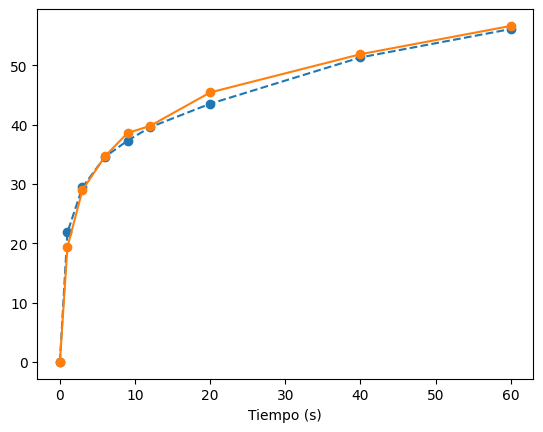

In [8]:
bayes_opt.best_params

e_ads, e_int_abs, lattice_size = bayes_opt.best_params
kmc_model = KineticMonteCarlo(lattice_size=lattice_size, e_ads=e_ads, e_int_abs=e_int_abs, time_factor=1e-7, time_array=time_array)
kmc_model.run_simulation()

simulated_data = np.array(list(kmc_model.occupancy.values()))
plt.plot(time_array, exp_data, label="Datos experimentales", marker="o", linestyle="--")
plt.plot(time_array, simulated_data, label="Datos simulados", marker="o")
plt.xlabel("Tiempo (s)")


In [12]:
N = 1000  # Número de simulaciones
curves = []
times = []

for _ in range(N):
    KMC = KineticMonteCarlo(lattice_size=lattice_size, e_ads=e_ads, e_int_abs=e_int_abs, time_factor=1e-7, time_array=time_array)
    KMC.run_simulation()
    curves.append(KMC.occupancy.values())
    times.append(KMC.time_array)

Mean values:  [ 0.      22.03783 29.09122 34.31149 37.65912 40.13128 44.79631 51.72889
 56.0234 ]
Standard deviation values:  [0.         1.75646906 1.63548033 1.41241927 1.25841863 1.16092589
 1.0379638  0.87203573 0.78098821]


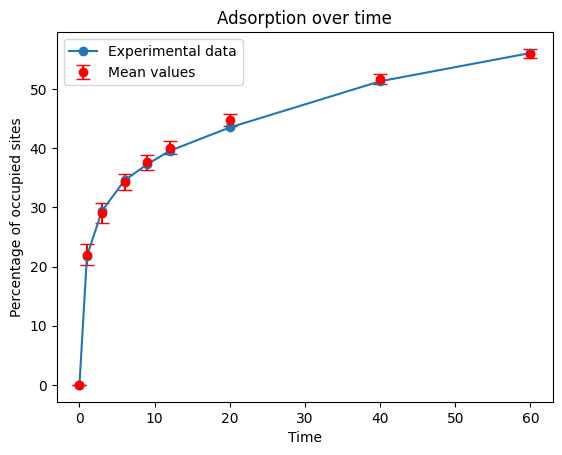

In [13]:
df = pd.DataFrame(curves)
mean_values = df.mean().to_numpy()
std_values = df.std().to_numpy()

print("Mean values: ", mean_values)
print("Standard deviation values: ", std_values)

plt.errorbar(time_array, mean_values, yerr=std_values, capsize=5, color='red', fmt='o', label='Mean values')
plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.legend()


### Reducción de variabilidad en los resultados kMC

https://chatgpt.com/share/67c653e7-efa4-800c-8818-6a60bf2d7bfa